# Lab05 Exercises #1

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean  

## Objectives
* Learn how to inspect, read and write raster data
* Develop a more intuitive understanding of raster transforms, window/extent operations
* Understand raster visualization approaches, contrast stretching and interpolation settings
* Perform common raster band math operations (e.g., NDVI) using NumPy
* Perform quantitative raster analysis using value thresholds and binary masks
* Understand programmtic Landsat-8 archive access and download

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rasterio as rio
import rasterio.plot
from osgeo import gdal

#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar

## Part 0: Run Landsat data download notebook, set path to data directory
* 05_Raster1_LS8_download.ipynb

In [2]:
pwd

'/home/jovyan/project/chelanigans'

In [3]:
#Open accompanying notebook and Run All Cells
#Alternatively, can run from this notebook, which should preserve variables/state
#%run /home/jovyan/labs/jupyterbook/book/modules/05_Raster1_GDAL_rasterio_LS8/05_Raster1_LS8_download.ipynb

In [4]:
#Set path to local directory with downloaded images
imgdir = '/home/jovyan/project/chelanigans/LS8_sample'

In [67]:
## CAREFUL: PATH AND ROW ARE HARDCODED HERE




#Pre-identified cloud-free Image IDs used for the lab
#Summer 2018
img_id1 = 'LC08_L2SP_045027_20180818_20200831_02_T1'
#Winter 2018
img_id2 = 'LC08_L2SP_045027_20181224_20200829_02_T1'

In [68]:
#Define image to use (can set this to switch to winter image)
img = img_id1

In [69]:
#Red band filename
r_fn = os.path.join(imgdir, img+'_SR_B4.TIF')

## Part 1: Raster basics

### Open the downloaded image from disk
* Since we already downloaded these images locally, let's just open a local file
* Let's use of the red band (B4) TIF file
    * We already defined the `r_fn` above, so this should be easy
* Don't use the `with` construct - store the opened dataset in a variable, so we can use in other cells

In [70]:
print(r_fn)
src = rio.open(r_fn)

/home/jovyan/project/chelanigans/LS8_sample/LC08_L2SP_045027_20180818_20200831_02_T1_SR_B4.TIF


RasterioIOError: /home/jovyan/project/chelanigans/LS8_sample/LC08_L2SP_045027_20180818_20200831_02_T1_SR_B4.TIF: No such file or directory

### What is the CRS of the dataset?
* Look familiar?  The `fiona` functionality underlying `rasterio` (also used by `geopandas`) was mostly written by the same author (Sean Gilles, https://github.com/sgillies). 
* If you don't recognize it by now, take a minute to look up this EPSG code

In [71]:
src.crs

CRS.from_epsg(32610)

### What is the raster extent (bounds) of the dataset in projected coordinates?
* Note that this is not a simple python `list` object, but a special rasterio [`BoundingBox` object](https://rasterio.readthedocs.io/en/latest/api/rasterio.coords.html#rasterio.coords.BoundingBox) with attributes for `left`, `bottom`, etc.
    * This helps you avoid mixing up order of values that correspond to `(min_x, min_y, max_x, max_y)`
    * Note that other API and utilities may use different order (e.g., `min_x, max_x, min_y, max_y`)

In [10]:
src.bounds

BoundingBox(left=473685.0, bottom=5136885.0, right=706815.0, top=5373615.0)

### How many bands are there in this dataset?
* Check the approprate rasterio dataset attribute

In [11]:
print("There is " +str(src.count) + " band in this dataset.")

There is 1 band in this dataset.


### Review the profile and metadata record
* Inspect the rasterio `profile` and `meta` attributes, which should return dictionaries for all metadata

In [12]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7771, 'height': 7891, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473685.0,
       0.0, -30.0, 5373615.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [13]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 7771,
 'height': 7891,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'transform': Affine(30.0, 0.0, 473685.0,
        0.0, -30.0, 5373615.0)}

### OK, let's read the raster data into a NumPy array and preview
* Store the output array as a new variable called `r`
* Use default read options for now, don't read as masked array
* What band number should we use here? 
    * This dataset is for the red Landsat multispectral band, which is band #4 (B4)
    * But each Landsat band is stored as a separate TIF file (remember your dataset band `count` attribute above)
    * So using rasterio `read`, which band do you need to load?
    * Note: If you omit the band number, rasterio will return a 3D NumPy array with an additional dimension

In [14]:
r = src.read(1)
r

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

### What are the dimensions of the NumPy array?  
* Compare this with the rasterio dataset `width` and `height` attributes
    * Look carefully, as these are slightly different
    * Hopefully this offers a reminder about the ordering of NumPy indices, with (row, col) representing (y,x) dimensions

In [15]:
print("rasterio width (x): " +str(src.width))
print("rasterio height (y): " +str(src.height))

rasterio width (x): 7771
rasterio height (y): 7891


In [16]:
print("numpy dimensions as (y,x): " +str(r.shape))

numpy dimensions as (y,x): (7891, 7771)


### What is the uncompressed filesize of this array in Megabytes?
* You can compute this using the array data type and dimensions
    * Can check with the NumPy array `nbytes` attribute
* This is how much RAM the array is occupying after the read operation
* How does this compare with the file size of the `*B4.TIF` file on disk (from earlier `ls -alh`)?
    * If different, why might they be different? ✍️

In [17]:
r.dtype

dtype('uint16')

In [18]:
# 16 bits * 1 byte/ 8 bits = 2 bytes
src.width * src.height * 2

122641922

In [19]:
r.nbytes

122641922

In [20]:
%cd /home/jovyan/labs/jupyterbook/book/modules/05_Raster1_GDAL_rasterio_LS8/LS8_sample

[Errno 2] No such file or directory: '/home/jovyan/labs/jupyterbook/book/modules/05_Raster1_GDAL_rasterio_LS8/LS8_sample'
/home/jovyan/project/chelanigans


In [21]:
%ls -alh

#a = all, do not ignore entries beginning with "."
#l = long listing format
#h = human readable

total 14M
drwxrwsr-x 5 jovyan users 4.0K Mar  7 02:49 ./
drwxrwsr-x 3 jovyan users 4.0K Feb 22 04:58 ../
drwxrwsr-x 8 jovyan users 4.0K Feb 24 20:28 .git/
-rw-rw-r-- 1 jovyan users 1.8K Feb 22 04:58 .gitignore
drwxrwsr-x 2 jovyan users 4.0K Mar  7 02:23 .ipynb_checkpoints/
drwxr-sr-x 2 jovyan users 4.0K Mar  7 02:29 LS8_sample/
-rw-rw-r-- 1 jovyan users 4.5K Mar  7 02:48 README.md
-rw-r--r-- 1 jovyan users 1.0M Mar  7 02:49 window_bounds_dl.ipynb
-rw-r--r-- 1 jovyan users 228K Mar  7 02:32 window_bounds_download.ipynb
-rw-r--r-- 1 jovyan users  13M Mar  7 02:48 window_bounds.ipynb


### Answer:  
* 83 MB in summer .TIF file
* 122 MB as an array  
  
I would think the difference is in how the data is packed.   
As a .TIF file, the information is stored more concisely (compressed).  
As an array, the data is all unpacked. 

### Create a plot of the image
* Earlier we used the `rio.plot.show()` convenience function for plotting a dataset, which is a wrapper around the standard matplotlib `imshow()`.  Here, let's create a figure/axes and use matplotlib `imshow` to view the array.
* Use the `gray` color ramp (see `imshow` doc on how to specify color ramp)
* If using `%matplotlib widget` backend, I recommend you start with `f,ax = plt.subplots()`, which will create a new figure in the cell (otherwise, your `imshow` output could end up in an earlier figure).

In [22]:
plt.imshow?

Signature:
plt.imshow(
    X,
    cmap=None,
    norm=None,
    *,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    interpolation_stage=None,
    filternorm=True,
    filterrad=4.0,
    resample=None,
    url=None,
    data=None,
    **kwargs,
)
Docstring:
Display data as an image, i.e., on a 2D regular raster.

The input may either be actual RGB(A) data, or 2D scalar data, which
will be rendered as a pseudocolor image. For displaying a grayscale
image set up the colormapping using the parameters
``cmap='gray', vmin=0, vmax=255``.

The number of pixels used to render an image is set by the Axes size
and the *dpi* of the figure. This can lead to aliasing artifacts when
the image is resampled because the displayed image size will usually
not match the size of *X* (see
:doc:`/gallery/images_contours_and_fields/image_antialiasing`).
The resampling can be controlled via the *interpolation* parameter
and/or :rc:`imag

In [23]:
#%matplotlib widget
%matplotlib inline

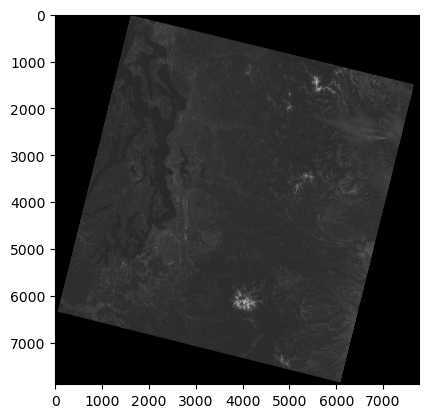

In [24]:
fig, ax = plt.subplots()
plt.imshow(r, cmap='gray');

* Note that the Landsat-8 image appears "rotated" relative to the axes
    * Why is this? ✍️
* Note the array coordinate system (where is the (0,0) origin)
* Interactively look at coordinates and the digital number (DN) values as you move your mouse over the image
    * The DN is the unsigned integer value, but not yet a calibrated surface reflectance value (which would have dimensionless values over the range 0.0-1.0)
    * Check DN values over Mt. Rainier, Puget Sound, and the outer "black" border

### Answer:  
* it is rotated because that is the path the satelite took over the region (bottom left to top right, or vice versa)

## Part 2: Histograms, NoData and Masked Arrays

### Create a histogram plot of raster values in your array
* Does the matplotlib `hist()` expect a 2D array or a 1D array?
    * Remember to use the NumPy `ravel()` function on your array when passing to `hist()`!
* Make sure you use enough bins!  Try at least ~200.
* 🤔 Which bin has the highest count of pixels?
* 🤔 Over what range do most of the raster values fall?
    * Is this consistent with the original 12-bit sensor bit depth (2^12 possible values) and 16-bit integer data type (2^16 possible values)?

In [25]:
%matplotlib inline
#%matplotlib widget

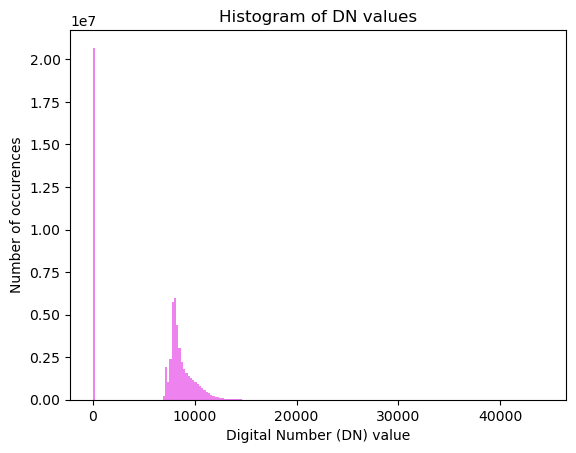

In [26]:
fig, ax = plt.subplots()

ax.hist(r.ravel(), bins=200, color='violet')
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Digital Number (DN) value')
ax.set_title('Histogram of DN values');

In [27]:
src.nodata

0.0

### Let's get rid of that black border (nodata values)
* The Level-2 Landsat-8 images have a `nodata` value set in the image metadata, but we did not use this when reading
* As a result, the 0 values around the margins are considered "valid" pixels, and these appear black in our grayscale color ramp
* We have a few options to deal with missing data (read through both before starting):
    1. Set values of 0 to `np.nan`
        * Remember that `np.nan` is a special `float` object, so for this approach, you must first convert the entire array using `astype(float)`
            * This means we unnecessarily increase the amount of RAM required to store the same `UInt16` (2 byte) image DN values by a factor of 2x or 4x, as each `float32` value occupies 4 bytes, and the default NumPy `float` is actually `float64` or 8 bytes!  This increased memory requirement can be a real issue for large arrays. 
            * For this reason, I suggest that you work with masked arrays (Option 2) for rasters with integer data types and nodata defined.
        * Note that there are a growing number of "nan-aware" functions in NumPy (e.g., np.nanpercentile), but still limitations
        * Note that some packages like Pandas and xarray don't currently support masked ararys, but rely on `np.nan` for missing values
    2. Use a NumPy masked array (should be simple one-liner)
        * Take a few minutes to read about masked arrays
            * https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html#what-is-a-masked-array
            * https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html
            * Masked arrays allow for masking invalid values on any datatype (like `Byte` or `UInt16`)
                * Stores the mask as an additoinal 1-bit boolean array
        * See the `masked_equal` function to create a masked array from an existing array 
    3. Use the `masked=True` option when reading a band from the rasterio dataset (with NoData properly set)
        * For example `r = src.read(1, masked=True)`
        * More info on rasterio nodata handling and more advanced masking support: https://rasterio.readthedocs.io/en/latest/topics/masks.html

### Prepare a masked array for the red band using one of the approaches above
* Preview your new array, inspect the mask
* Try plotting the masked array with imshow using the `gray` cmap
    * You should no longer see a black border around the valid pixels

In [28]:
#  Approach #2: Numpy masked array 
# (skipping approach #1)

import numpy.ma as ma

#r0 = r.ravel
r_m0 = ma.masked_values(r, 0)
r_m0

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

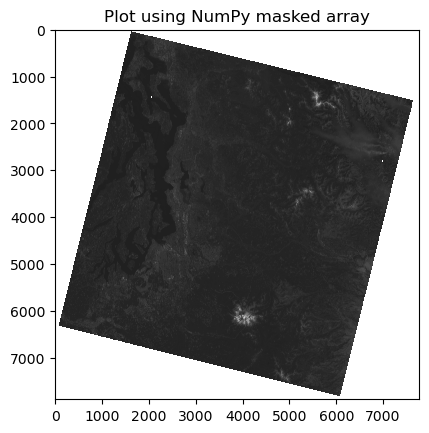

In [29]:
fig, ax = plt.subplots()

ax.imshow(r_m0, cmap='gray')
ax.set_title('Plot using NumPy masked array');

In [30]:
# Approach #3: utilizing masked=True option

r_m1 = src.read(1, masked=True)
r_m1

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

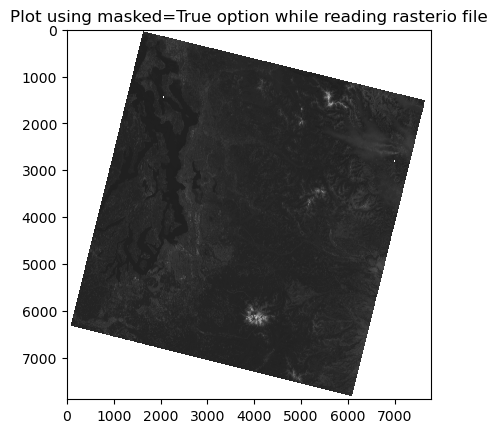

In [31]:
fig, ax = plt.subplots()

ax.imshow(r_m1, cmap='gray')
ax.set_title('Plot using masked=True option while reading rasterio file');

### Replot the histogram of your masked array
* Remember to covert your 2D masked array to 1D with `ravel()` or use the new masked array object method `compressed()` before passing to `hist()`, which expects a 1D array
* There should no longer be a spike for the 0 bin
* Experiment with `log=True` to the `hist` call to display logarithmic y axis for the bin counts

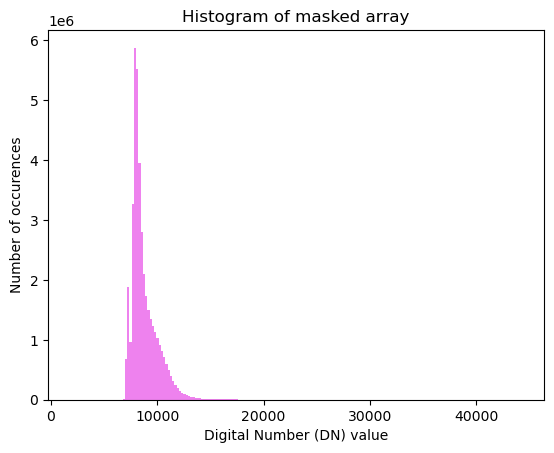

In [32]:
fig, ax = plt.subplots()

ax.hist(r_m1.ravel(), bins=200, color='violet', log=False)
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Digital Number (DN) value')
ax.set_title('Histogram of masked array');

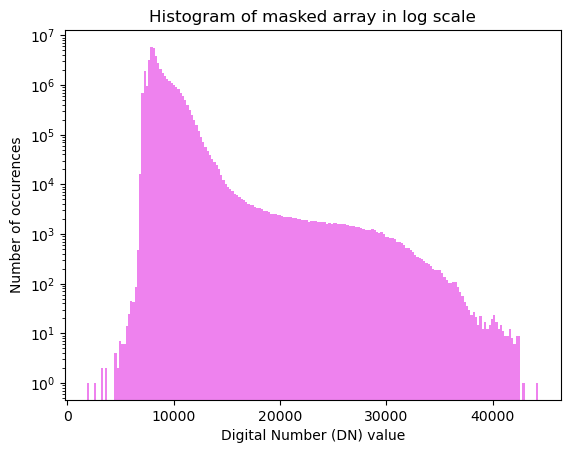

In [33]:
fig, ax = plt.subplots()

ax.hist(r_m1.ravel(), bins=200, color='violet', log=True)
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Digital Number (DN) value')
ax.set_title('Histogram of masked array in log scale');

## Scale the 16-bit values to geophysical variables - surface reflectance and temperature
* We want to multiply the masked array values by the known scaling factor and then add the known offset value - these are provided by the Landsat project
    * See conversion factors here: https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products
    * https://www.usgs.gov/faqs/how-do-i-use-scale-factor-landsat-level-2-science-products
* Store the output as a separate array 
* Units:
    * Unitless surface reflectance values from 0.0 to 1.0
    * Surface temperature values in Kelvin - can convert to Celsius

In [34]:
#Surface Reflectance 0.0000275 + -0.2
sr_scale = 0.0000275
sr_offset = -0.2
#Surface Temperature 0.00341802 + 149.0
st_scale = 0.00341802
st_offset = 149.0

In [35]:
sr = r_m1 * sr_scale + sr_offset
st = r_m1 * st_scale + st_offset

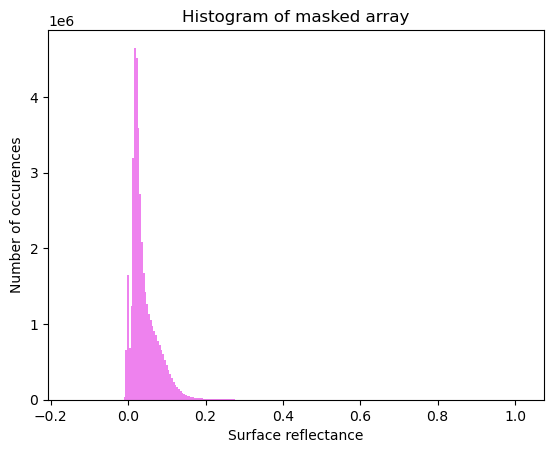

In [36]:
fig, ax = plt.subplots()

x = sr.compressed().ravel()

ax.hist(x, bins=256, color='violet', log=False)
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Surface reflectance')
ax.set_title('Histogram of masked array');

### Print the min and max values of the original, masked, and scaled arrays
* Note that 0 is no longer the minimum in the scaled values

In [37]:
this_list = [('original', r),
             ('masked', r_m1),
             ('scaled surface reflectance', sr),
             ('scaled surface temperature', st)
            ]
for name, array in this_list:
    print('For the %s array: min=%.3f max=%.3f' % (name, array.min(), array.max()));
    
#NOTE: use %s when referring to string and %f when referring to float

For the original array: min=0.000 max=44254.000
For the masked array: min=1867.000 max=44254.000
For the scaled surface reflectance array: min=-0.149 max=1.017
For the scaled surface temperature array: min=155.381 max=300.261


### Determine the pixel values representing the 2nd and 98th percentile
* These percentile values are commonly used to automatically set the `vmin` and `vmax` when plotting (e.g., in QGIS)
    * See `imshow` documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
* Note that if you're using a masked array, you will need to isolate unmasked values using the `compressed()` method before passing to regular NumPy functions like `np.percentile`
* Plot these as vertical dotted black lines on a histogram
    * Hopefully this helps visualize what these percentile values represent based on your distribution.

In [38]:
perc = np.percentile(sr.compressed(), (2, 98))
print(perc)

[-0.002605  0.134785]


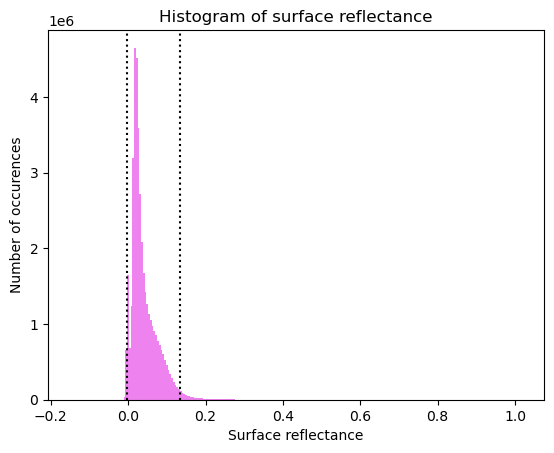

In [39]:
fig, ax = plt.subplots()

ax.hist(sr.compressed().ravel(), bins=256, color='violet', log=False)
ax.axvline(perc[0], ls=':', c='k')
ax.axvline(perc[1], ls=':', c='k')

ax.set_ylabel('Number of occurences')
ax.set_xlabel('Surface reflectance')
ax.set_title('Histogram of surface reflectance');

## Part 3: Raster transform
* Inspect the dataset `transform` attribute
* Review this: https://rasterio.readthedocs.io/en/stable/topics/georeferencing.html?highlight=affine#coordinate-transformation

In [40]:
src.transform

Affine(30.0, 0.0, 473685.0,
       0.0, -30.0, 5373615.0)

### In your own words, what does this thing do? ✍️

### ANSWER:  
* This contains the scale factors to be used in matrix calculations which transform the data from the pixel coordinate system to a geographic coordinate system.

### Calculate corner coordinates
* Use the transform to calculate the projected coordinates of the array corners
* Use the rasterio dataset `bounds` attribute to get the "truth" (you already did this)
* Creating tuples of array corner pixel coordinates (e.g. `[(0,0), (array.shape[1], 0), ...]`
    * Useful to think of corners as upper left, upper right, lower right, lower left
    * *Careful about mixing (rows, columns) and (x, y) coordinates!*
    * I recommend you draw a quick sketch for this exercise
* Use the affine transformation to convert to projected coordinates
    * This should be pretty easy to do - can directly multiply the Affine transform by the (x,y) coordinate tuple

In [41]:
#upper left
ul = [0, 0]
ul_proj = src.transform * ul

#lower left
ll = [0, sr.shape[0]]
ll_proj = src.transform * ll

#upper right
ur = [sr.shape[1], 0]
ur_proj = src.transform * ur

#lower right
lr = [sr.shape[1], sr.shape[0]]
lr_proj = src.transform * lr

In [42]:
bounds_proj = (ul_proj, ll_proj, ur_proj, lr_proj)
bounds_proj

((473685.0, 5373615.0),
 (473685.0, 5136885.0),
 (706815.0, 5373615.0),
 (706815.0, 5136885.0))

In [43]:
src.bounds

BoundingBox(left=473685.0, bottom=5136885.0, right=706815.0, top=5373615.0)

I'm showing the above coordinates as arrays, but you can work with each corner individually

### Compute total dimensions of the projected raster dataset in km
* Use the coordinates for your corners
* Sanity check! Look up the actual LS-8 image footprint dimensions in km - make sure your calculated values are somewhat consistent. They may be different due to projection!

In [44]:
wh_km = np.abs(np.array(ul_proj) - np.array(lr_proj))/1000
wh_km
print('Total width: %0.2f km\nTotal height: %0.2f km' % (wh_km[0], wh_km[1]))

Total width: 233.13 km
Total height: 236.73 km


### LS-8 image footprint dimensions are ~185km

if we're talking about a 50km ballpark, we are in it
    
source: https://www.usgs.gov/landsat-missions/landsat-8#:~:text=Landsat%208%20images%20have%2015,km%20(115%20mi)%20swath.  


### Determine the array indices (row, column) of the center pixel in the image
* Try to use array attributes (like `shape`) here, instead of hardcoding values
* Note that we have an odd number of rows and columns in this array, so may need to round to nearest integer values

In [45]:
sr.shape

(7891, 7771)

In [46]:
# Remember, shape attribute is given as (y,x)

center_row = sr.shape[0]//2
center_col = sr.shape[1]//2

center = (center_col, center_row)
print(center)
print('(col, row)')

# NOTE: rounding down here with //

(3885, 3945)
(col, row)


### Determine the surface reflectance value at this center pixel using array indexing
* Don't overthink this, just extract a value from the numpy array for the (row, col) indices you determined
    * You've done this kind of thing before, (e.g., `myarray[0,0]`)
* Make sure you are using integer values here (may need to convert/round), or NumPy will return an `IndexError`
* Do a sanity check on an interactive `imshow` plot to check values near the center of the image

In [47]:
sr_center = sr[center_row, center_col]
print('Surface reflectance value at center pixel is: %0.3f' % (sr_center))

Surface reflectance value at center pixel is: 0.018


In [48]:
#%matplotlib widget
%matplotlib inline

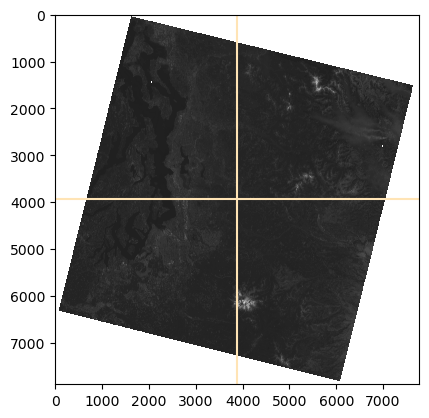

In [49]:
fig, ax = plt.subplots()

ax.imshow(sr, cmap='gray')
ax.axvline(center_col, c='moccasin')
ax.axhline(center_row, c='moccasin');

### Determine the projected coordinates (meters in UTM 10N) of the center pixel
* Review the rasterio dataset `xy` method: https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.TransformMethodsMixin.xy
    * Careful about the order of your row and column indices
* Sanity check the resulting projected coordinates with rasterio dataset `index` method - this should return your (row, col) indices
    * https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.TransformMethodsMixin.index
    * These may be rounded to nearest integer
* These two functions allow you to go back and forth between the image/array coordiantes and the projected coordinate system!

In [50]:
center_utm = src.transform * center
print('The upper left corner of the center pixel is located at ' +str(center_utm))

The upper left corner of the center pixel is located at (590235.0, 5255265.0)


In [51]:
src.xy?

Signature:
src.xy(
    row,
    col,
    z=None,
    offset='center',
    transform_method=<TransformMethod.affine: 'transform'>,
    **rpc_options,
)
Docstring:
Get the coordinates x, y of a pixel at row, col.

The pixel's center is returned by default, but a corner can be returned
by setting `offset` to one of `ul, ur, ll, lr`.

Parameters
----------
row : int
    Pixel row.
col : int
    Pixel column.
z : float, optional
    Height associated with coordinates. Primarily used for RPC based 
    coordinate transformations. Ignored for affine based 
    transformations. Default: 0.
offset : str, optional
    Determines if the returned coordinates are for the center of the
    pixel or for a corner.
transform_method: TransformMethod, optional 
    The coordinate transformation method. Default: `TransformMethod.affine`.
rpc_options: dict, optional
    Additional arguments passed to GDALCreateRPCTransformer

Returns
-------
tuple
    x, y
File:      /srv/conda/envs/notebook/lib/python3.10

In [52]:
# Location defaults to center of pixel.
# To change to ul, ll, ur, lr: pass in the `offset=` option

center_xy = src.xy(center_row, center_col)
print('The center of the center pixel is located at ' +str(center_xy))

# Input is row, col
# Output is x, y

The center of the center pixel is located at (590250.0, 5255250.0)


In [53]:
src.index(center_xy[0], center_xy[1])

#Note: input order is x, y
#      output order is row, col

(3945, 3885)

### Extra Credit: sample the rasterio dataset (extract the raster value) using these projected coordinates
* This doesn't require reading the array, but can be run on the src dataset for a list of (x,y) coordinates
* See https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html (this is not a helpful example, see ex below or demo file)
* https://uwgda-jupyterbook.readthedocs.io/en/latest/modules/05_Raster1_GDAL_rasterio_LS8/05_Raster1_GDAL_rasterio_Demo.html#raster-and-array-sampling

* Note that this will return an iterable generator, so will need to evaluate (can encompass in `list()` operator)
* The resulting DN value should be similar to the value you extracted directly from the array

In [54]:
list(src.sample([(center_xy)]))

# failed attempts below
#list(rio.sample.sample_gen(src, center_xy))
#rio.sample.sample_gen(src, center_xy)

[array([7914], dtype=uint16)]

### Now, apply what you've learned!
What is the raster value at the following projected coordinates:
* (522785.0, 5323315.0)
* (`src.bounds.left + 50000`, `src.bounds.top - 50000`)

In [55]:
pc1 = src.index(522785.0, 5323315.0)
pc2 = src.index(src.bounds.left + 50000, src.bounds.top - 50000)

ras_1 = sr[pc1]
ras_2 = sr[pc2]
print('Raster value at row,col ' +str(pc1) + ' is: %0.3f' % (ras_1))
print('Raster value at row,col ' +str(pc2) + ' is: %0.3f' % (ras_2))

Raster value at row,col (1676, 1636) is: 0.018
Raster value at row,col (1666, 1666) is: -0.003


## Part 4: Raster visualization with real-world coordinates and scalebar

### Extract the full-image `extent` in projected coordinates to pass to matplotlib `imshow`
* Start with the rasterio dataset bounds
* See doc on imshow `extent` parameter here: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
* Note that the matplotlib `extent` is similar to the rasterio `bounds`, but not identical!
    * Be careful about ordering of (left, bottom, right, top) vs. (min_x, max_x, min_y, max_y)!
        * Good to practice, as this comes up often when working with rasters using different tools
    * There is also the `rio.plot.plotting_extent()` convenience function to get the matplotlib `extent` for a rasterio Dataset: https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.plotting_extent

In [56]:
#This is rasterio bounds
src.bounds

BoundingBox(left=473685.0, bottom=5136885.0, right=706815.0, top=5373615.0)

In [57]:
#This is matplotlib extent
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[473685.0, 706815.0, 5136885.0, 5373615.0]


In [58]:
#rasterio convenience function
full_extent = rio.plot.plotting_extent(src)
print(full_extent)

(473685.0, 706815.0, 5136885.0, 5373615.0)


### Plot the image with `imshow`, but now pass in this `extent` as an argument
* Note how the axes coordinates change
    * These should now be meters in the UTM 10N coordinate system of the projected image!

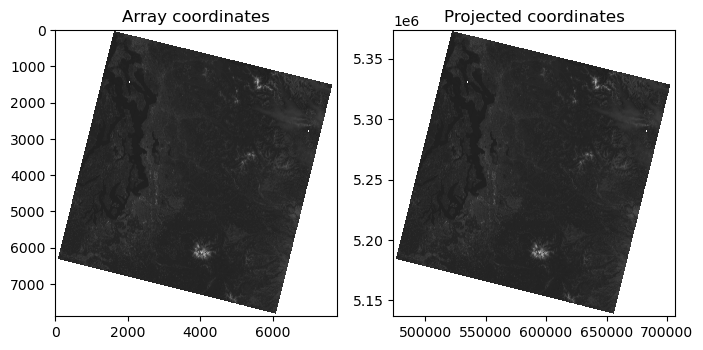

In [59]:
full_extent = rio.plot.plotting_extent(src)

fig, axa = plt.subplots(1, 2, figsize=(8,6))

axa[0].imshow(sr, cmap='gray')
axa[0].set_title('Array coordinates')

axa[1].imshow(sr, cmap='gray', extent=full_extent)
axa[1].set_title('Projected coordinates');

### Add a dynamic scalebar to the above plot
* We will use the `matplotlib-scalebar` package for this
* See documentation: https://github.com/ppinard/matplotlib-scalebar
> The constructor arguments dx and units specify the pixel dimension. For example scalebar = ScaleBar(0.2, 'um') indicates that each pixel is equal to 0.2 micrometer. If the the axes image has already been calibrated by setting its extent, set dx to 1.0.
    * In other words:
        * For imshow using array coordinates (without defining `extent`), use `ax.add_artist(ScaleBar(res))` where res is the pixel resolution in meters
        * For imshow using projected coordinates with `extent` defined, use `ax.add_artist(ScaleBar(1.0))` because one unit in the axes coordinate system is equal to 1 m
* If using interactive matplotlib backend, note what happens to the scalebar when you zoom

In [60]:
#%matplotlib widget
%matplotlib inline

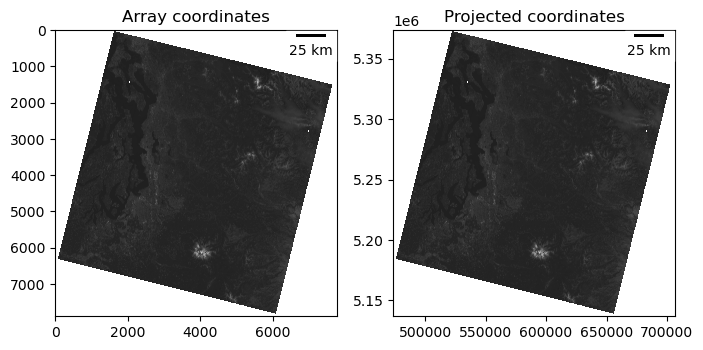

In [61]:
full_extent = rio.plot.plotting_extent(src)

fig, axa = plt.subplots(1, 2, figsize=(8,6))

#image resolution is same as pixel size
res=30

axa[0].imshow(sr, cmap='gray')
axa[0].set_title('Array coordinates')
axa[0].add_artist(ScaleBar(res))

axa[1].imshow(sr, cmap='gray', extent=full_extent)
axa[1].set_title('Projected coordinates')
axa[1].add_artist(ScaleBar(1.0));

## Part 5: Raster window extraction

### Review: array indexing
* We could continue our analysis with the full images, but for many science and engineering applications, we only care about a small subset of a raster at any given time
* It's also a good practice to prototype new workflows using a small subset of data
    * Less memory usage, much faster processing, faster debugging
    * Remember this for your project!  Don't start with full-resolution raster data.
* One way to accomplish this might be to extract a portion of the large array using slicing/striding (see the Lab03 NumPy section)
    * Maybe a good time to review https://numpy.org/doc/stable/user/basics.indexing.html#slicing-and-striding
* To extract a 1024x1024 px chunk of the full-size array, we could do something like:

In [62]:
sr.shape

(7891, 7771)

In [63]:
chunk = sr[3000:4024,3000:4024]

In [64]:
chunk.shape

(1024, 1024)

### Extra Credit: extract a 256x256 pixel window around the center pixel of the array
* You already determined the center pixel indices earlier
* You'll need to define the appropriate slices for both rows and columns
    * Use variables to define window dimensions, rather than hardcoding 256 or 128
* Preview the resulting 256x256 pixel array

In [65]:
pix = 256

min_row = int(center_row - (pix/2))
max_row = int(center_row + (pix/2))
min_col = int(center_col - (pix/2))
max_col = int(center_col + (pix/2))

chunk = sr[min_row:max_row, min_col:max_col]
chunk.shape

(256, 256)

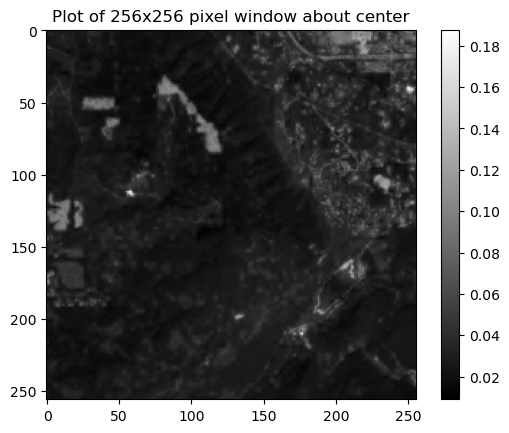

In [66]:
fig, ax = plt.subplots()

shw = ax.imshow(chunk, cmap='gray')
bar = plt.colorbar(shw)

ax.set_title('Plot of 256x256 pixel window about center')
plt.show();

#https://www.geeksforgeeks.org/imshow-with-two-colorbars-under-matplotlib/

## Nice Job! 
* Save, then `git add` and `git commit` this notebook
* Shut down the kernel to free RAM
* Proceed to Notebook #2!
    * We will explore the with rasterio `window` functionality to extract windows directly from the original tif files, then do all kinds of cool raster analysis with the resulting arrays